In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import beta, binomial, dirichlet, multinomial

%matplotlib inline  

In [2]:
def initialize(V, N, labels, a=1.0, b=1.0, eta=1.0):
    pi = beta(a, b)
    L = binomial(1, pi, N)
    for n in range(N):
        if labels[n] == -1: continue
        L[n] = labels[n]
    theta_0, theta_1 = dirichlet([eta] * V, 2)
    return theta_0, theta_1, L

In [3]:
def generate_data(V, N, M=100, a=1.0, b=1.0, eta=1.0):
  theta_0, theta_1, labels = initialize(V, N, [-1] * N, a=a, b=b, eta=eta)
  corpus = []
  for n in range(N):
    theta = theta_0 if labels[n] == 0 else theta_1
    corpus.append(multinomial(M, theta))
  return corpus, labels    

In [4]:
def update(theta_0, theta_1, L, corpus, labels, a=1.0, b=1.0, eta=1.0):

    N = len(corpus)
    V = len(corpus[0])
    
    C = [len([l for l in L if l == 0]), len([l for l in L if l == 1])]
    
    # compute current words counts:
    cnts = []
    for v in range(V):
        word_cnts = [a, b]
        for n in range(N):
            word_cnts[L[n]] += corpus[n][v]
        cnts.append(word_cnts)
    
    # update document labels
    for n in range(N):
        l = L[n]
        if labels[n] == -1:
            # subtract document's word counts from the corresponding class counts:
            for v in range(V):
                cnts[v][l] -= corpus[n][v]
            # subtract 1 from class counts for the corresponding label:
            C[l] -= 1
            # compute document label probabilities
            if C[0] == 0: p = 1.0
            elif C[1] == 0: p = 0.0
            else:
              # compute the product of probabilities (sum of logs)
              value0 = np.log(float(C[0])/(N+a+b-1))
              value1 = np.log(float(C[1])/(N+a+b-1))
              for v in range(V):
                  value0 += np.log(theta_0[v])*corpus[n][v]
                  value1 += np.log(theta_1[v])*corpus[n][v]
              # Divide by a common number to avoid problems of small numbers.
              divisor = (value0+value1)/2
              value0 = np.exp(value0-divisor)
              value1 = np.exp(value1-divisor)
              p = value1 / (value0 + value1)
            # sample the new label:
            L[n] = binomial(1, p)
            # update document count for this label
            C[L[n]] += 1
            # add document's word counts from the corresponding class counts:
            for v in range(V): cnts[v][L[n]] += corpus[n][v]
      
    # sample new theta
    t0 = []
    t1 = []
    for v in range(V):
        t0.append(cnts[v][0])
        t1.append(cnts[v][1])
    theta_0 = dirichlet(t0)
    theta_1 = dirichlet(t1)
  
    return theta_0, theta_1, L

In [5]:
def sample(corpus, labels, iterations=100, a=1.0, b=1.0, eta=1.0):
    N = len(corpus)
    V = len(corpus[0])
    theta_0, theta_1, L = initialize(V, N, labels, a=a, b=b, eta=eta)
    trace = [L]
    
    for t in range(iterations):
        theta_0, theta_1, L = update(theta_0, theta_1, L, corpus, labels, a=a, b=b, eta=eta)
        trace.append(L)
    
    return trace

In [6]:
def compute_accuracy(N, p, L, true_labels):
    predicted_labels = [L[i] for i in range(int(N * p), N)] 
    correct = 0
    for i in range(0,len(predicted_labels)):
        if predicted_labels[i] == true_labels[i]: correct += 1
    accuracy = float(correct)/len(predicted_labels)
    return accuracy

In [7]:
def run_simulation(N=50, V=5, M=100, iterations=100, p=0.7, a=2, b=2, eta=1.0):
    corpus, labels = generate_data(V, N, M, a=a, b=b, eta=eta)
    # Partition the data into training and test sets:
    true_labels = []
    for i in range(int(N * p), N):
        true_labels.append(labels[i])
        labels[i] = -1
    trace = sample(corpus, labels, iterations=iterations, a=a, b=b, eta=eta)
    return compute_accuracy(N, p, trace[-1], true_labels)

Results: 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000
Average accuracy = 1.000


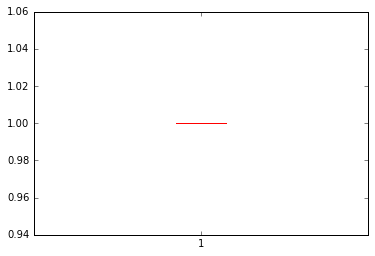

In [8]:
results = []
cnt = 0
while cnt < 10:
    accuracy = run_simulation(N=50, V=10, M=100, iterations=100, p=0.75, a=2, b=2, eta=1.0)
    results.append(accuracy)
    cnt += 1
print("Results: %s" % ", ".join("%0.3f" % x for x in results))
print("Average accuracy = %0.3f" % np.average(results))
plt.boxplot(results);

In [ ]:
%time accuracy = run_simulation(N=500, V=1000, M=100, iterations=100, p=0.75, a=2, b=2, eta=1.0)